<a href="https://colab.research.google.com/github/simakova-nadia/portfolio/blob/main/clustering_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Маркетинг.
[Данные с kaggle](https://www.kaggle.com/datasets/shwetabh123/mall-customers), посетители торгового центра.

Задача: разделить покупателей таким образом, чтоб можно было, работая с группами, увеличить доходы магазина. То есть кластеризовать для выводов, на основе которых строить дальнейшую маркетинговую стратегию.

Данные содержат следующую информацию о клиентах: ID клиента - порядковый номер (CustomerID), пол (Gender), возраст (Age), годовой доход (Annual_income) в тыс. долларов и оценка расходов (Spending_score). Оценка расходов — в оригинальных данных это назначенный клиенту от 1 (низший) до 99 (высший) счет на основе его поведения и данных о покупках.

In [ ]:
# Импорт библиотек и данных
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid") # Извините, у меня белая тема
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from sklearn.cluster import KMeans

link='/content/drive/MyDrive/Colab Notebooks/Mall_Customers.csv'
df = pd.read_csv(link, index_col='CustomerID')
df.rename(columns = {'Genre':'Gender','Annual_Income_(k$)':'Income','Spending_Score':'Score'}, inplace = True) # Исправление названий столбцов для упрощения обращения к ним

In [ ]:
# Данные
df

,Gender,Age,Income,Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [ ]:
df.dtypes

,0
Gender,object
Age,int64
Income,int64
Score,int64


In [ ]:
df.describe()

,Age,Income,Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [ ]:
# Проверка на пустые ячейки
df.isnull().sum()
# Пустых значений нет

,0
Gender,0
Age,0
Income,0
Score,0


In [ ]:
df.drop_duplicates(inplace=True) # Исключение дубликатов
df #Дубликатов нет

,Gender,Age,Income,Score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


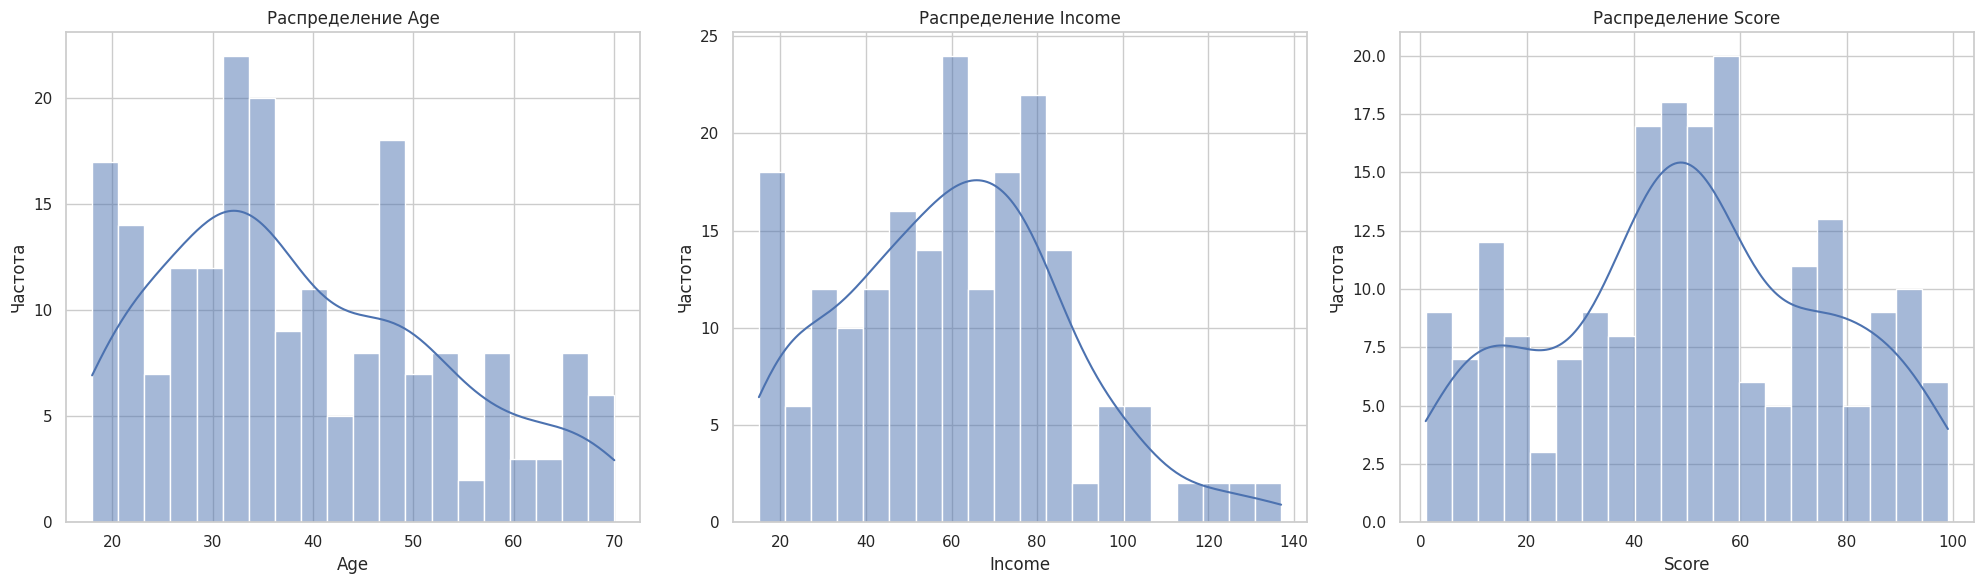

In [ ]:
# Визуализация плотности распределений
plt.figure(figsize=(20, 6))
n = 0
for x in ['Age', 'Income', 'Score']:
    n += 1
    plt.subplot(1, 3, n)
    sns.histplot(df[x], bins=20, kde=True)
    plt.title(f'Распределение {x}')
    plt.xlabel(x)
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

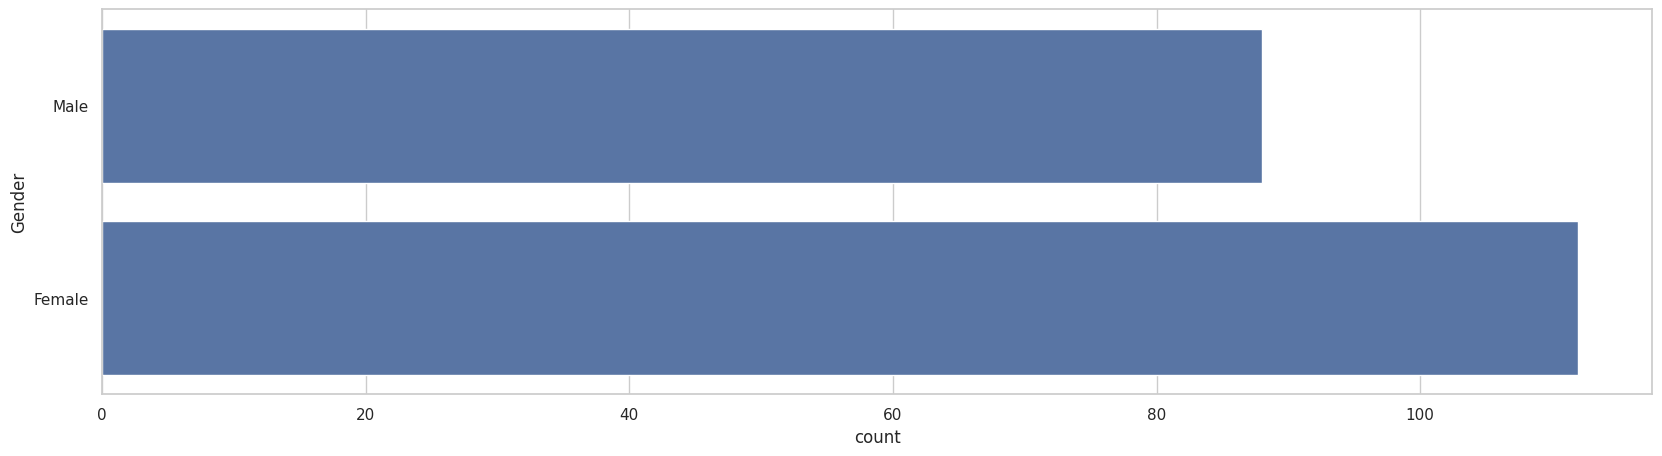

In [ ]:
plt.figure(1 , figsize = (20, 5)) # Гистограмма распределения по гендеру
sns.countplot(y = 'Gender' , data = df)
plt.show()

In [ ]:
# Оцифровка признака Gender: Female 0, Male 1
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

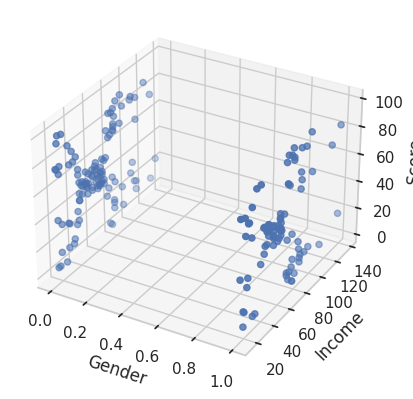

In [ ]:
# Проверка гипотезы о явном разделении на 2 кластера по гендеру
#3d построение

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['Gender']
y = df['Income']
z = df['Score']

ax.set_xlabel("Gender")
ax.set_ylabel("Income")
ax.set_zlabel("Score")
ax.scatter(x, y, z)
plt.show()
# Гипотеза подтвердилась

<Axes: xlabel='Score', ylabel='Income'>

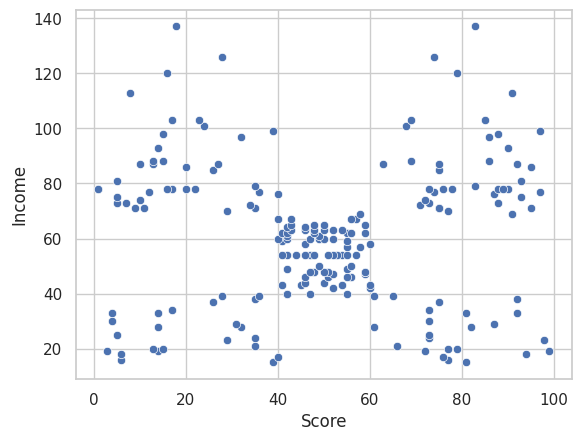

In [ ]:
# Рассмотрение только доходов и оценки расходов
df_solvency = df.drop(columns = ['Gender', 'Age'])
sns.scatterplot(data = df_solvency, x = "Score", y = "Income")

<Axes: xlabel='Score', ylabel='Income'>

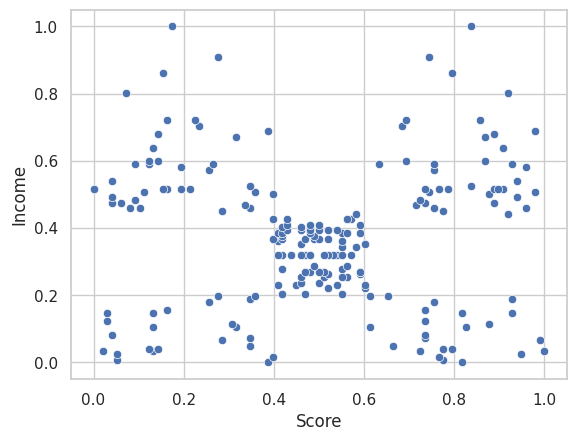

In [ ]:
# Использование линейной нормировки MinMaxScaler для нормализации данных
stand = preprocessing.MinMaxScaler()
X = stand.fit_transform(df_solvency)
X = pd.DataFrame(X, index = df_solvency.index, columns = df_solvency.columns)
sns.scatterplot(data = X, x = "Score", y = "Income")

In [ ]:
# Использование метода локтя (каменистой осыпи) для определения оптимального количества кластеров
wcss = [] # The within-cluster sum of squares (дисперсия)
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i) # По умолчанию метод k-means++
    kmeans.fit(X)
    # Метод inertia врозвращает меньшую wcss для этой модели
    wcss.append(kmeans.inertia_)

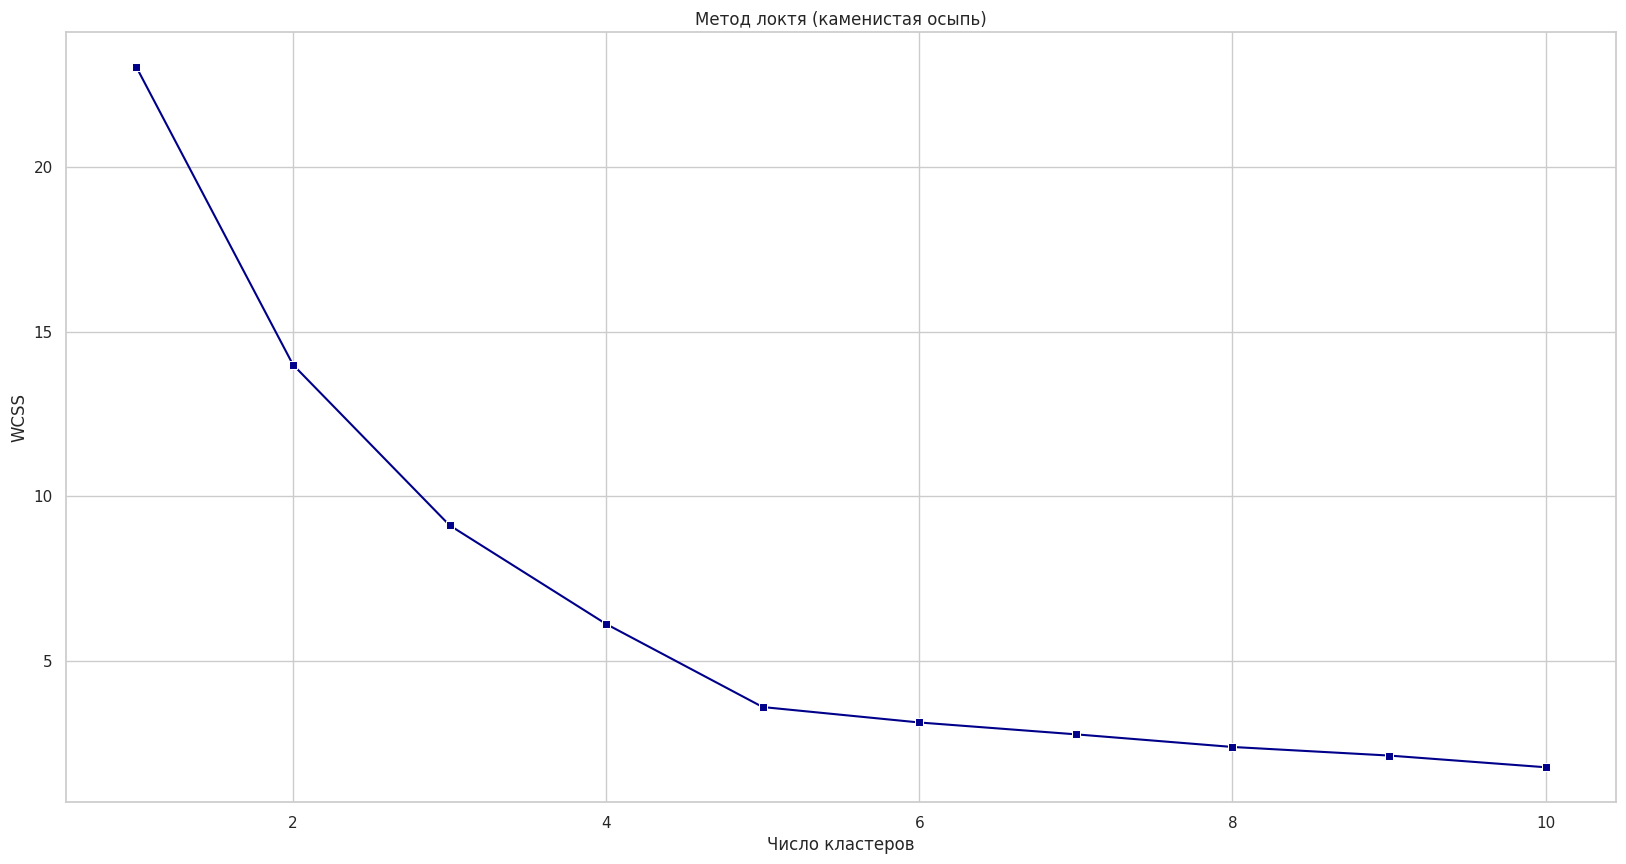

In [ ]:
# График
plt.figure(figsize=(20, 10))
sns.lineplot(x=range(1, 11), y=wcss, marker='s', color='darkblue')
plt.title('Метод локтя (каменистая осыпь)')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Проверка разбиения на 5 (график становится более покатый) кластеров, добавление количества кластеров
model = KMeans(n_clusters = 5, random_state = 24)
model.fit(X)
df_solvency['Cluster'] = model.labels_
df_solvency.groupby('Cluster').mean() # Группировка по кластерам с выводом средних

,Income,Score
Cluster,,
0,88.200000,17.114286
1,55.296296,49.518519
2,26.304348,20.913043
3,25.727273,79.363636
4,86.538462,82.128205


Получены 5 кластеров таким образом, что: А кластер - тратят много при большом доходе (любимые клиенты магазина); Б - тратят мало при малом доходе; В - тратят средне при среднем доходе; Г - тратят мало при большом доходе (экономные богачи, магазину нужно настраивать на них рекламу, призывая тратить больше); Д - тратят много при малом доходе (бедняки-транжиры, очень преданны магазину).

<Axes: xlabel='Score', ylabel='Income'>

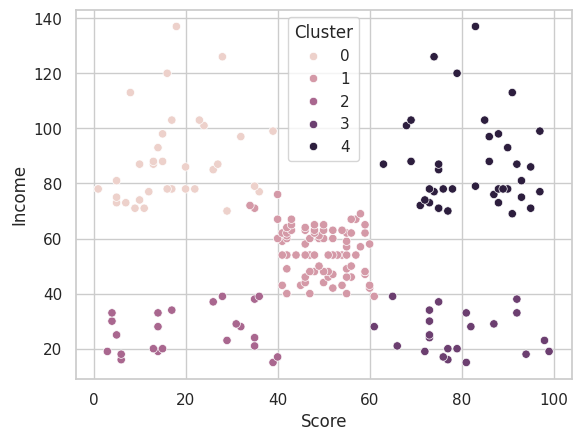

In [ ]:
sns.scatterplot(data = df_solvency, x = "Score", y = "Income", hue = "Cluster")

In [ ]:
# Проверка кластеризации с выводом средних на данных без исключения столбцов
df['Cluster'] = model.labels_
df.groupby('Cluster').mean()

,Gender,Age,Income,Score
Cluster,,,,
0,0.542857,41.114286,88.200000,17.114286
1,0.407407,42.716049,55.296296,49.518519
2,0.391304,45.217391,26.304348,20.913043
3,0.409091,25.272727,25.727273,79.363636
4,0.461538,32.692308,86.538462,82.128205


Средний показатель по гендеру можно интерпретировать следующим образом: в 0 кластере примерно поровну мужчин и женщин; в 1, во 2 и в 4 женщин чуть больше, чем мужчин; в 3 - мужчин чуть больше.


In [ ]:
# Проверка разбиения на 4 кластера
model = KMeans(n_clusters = 4, random_state = 24)
model.fit(X)
df_solvency['Cluster'] = model.labels_
df_solvency.groupby('Cluster').mean()

,Income,Score
Cluster,,
0,48.260000,56.480000
1,87.000000,18.631579
2,86.538462,82.128205
3,26.304348,20.913043


<Axes: xlabel='Score', ylabel='Income'>

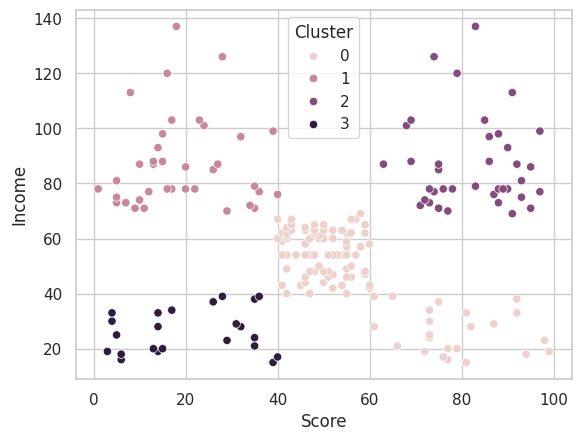

In [ ]:
sns.scatterplot(data = df_solvency, x = "Score", y = "Income", hue = "Cluster")

Люди, тратящие много при малом доходе объединились со средне тратящими при среднем доходе. Магазину такое распределение "потеряет" значимых клиентов.

То есть, кластеризация на 4 и менее кластеров нецелесообразна.

In [ ]:
# Проверка разбиения на 6 кластеров
model = KMeans(n_clusters = 6, random_state = 24)
model.fit(X)
df_solvency['Cluster'] = model.labels_
df_solvency.groupby('Cluster').mean()

,Income,Score
Cluster,,
0,78.551724,82.172414
1,55.097561,49.353659
2,25.727273,20.227273
3,88.200000,17.114286
4,25.727273,79.363636
5,109.700000,82.000000


<Axes: xlabel='Score', ylabel='Income'>

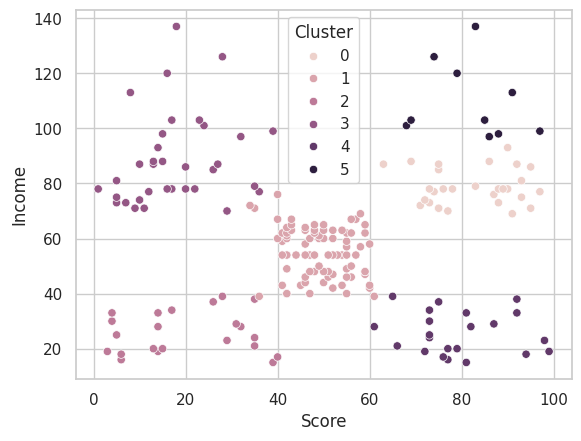

In [ ]:
sns.scatterplot(data = df_solvency, x = "Score", y = "Income", hue = "Cluster")

Кластер людей, много зарабатывающих и много тратящих, разделился на 2: зарабатывающие около 80 тыс. долларов и зарабатывающие около 110 тыс. долларов. Магазину это разделение целесообразно только в случае, если каждому покупателю из нового кластера прикрепить персональных менеджеров, подчеркнув таким образом их статусность.

На каких точно данных основана оценка расходов неясно, но можно предположить, что она зависит от доходов хотя бы потому, что человек не может потратить больше, чем зарабатывает (на это указывает предел оценки в 100).


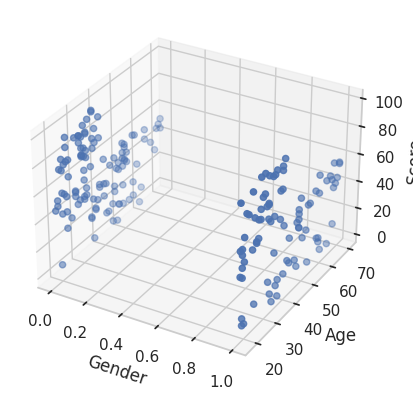

In [ ]:
# Проверка гипотезы с исключением дохода.
# Возраст, пол и оценка
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['Gender']
y = df['Age']
z = df['Score']

ax.set_xlabel("Gender")
ax.set_ylabel("Age")
ax.set_zlabel("Score")
ax.scatter(x, y, z)
plt.show()

<Axes: xlabel='Score', ylabel='Age'>

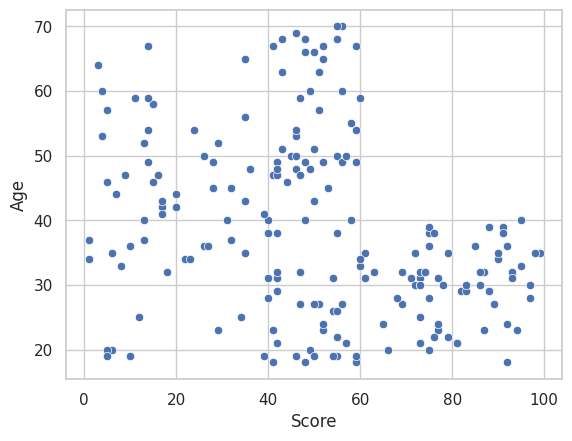

In [ ]:
# Снова исключение гендера и рассмотрение только возраста и оценки расходов
df_score = df.drop(columns = ['Gender', 'Income'])
sns.scatterplot(data = df_score, x = "Score", y = "Age")

<Axes: xlabel='Score', ylabel='Age'>

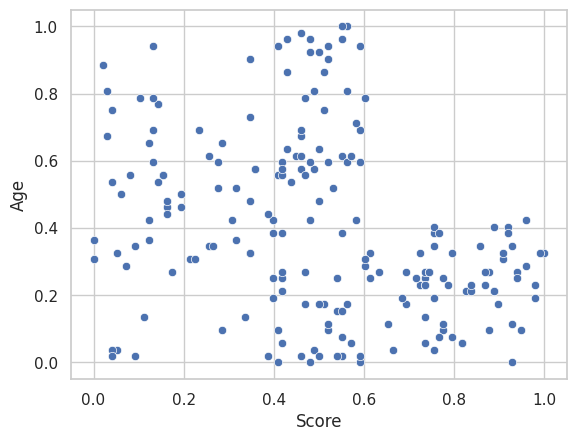

In [ ]:
stand = preprocessing.MinMaxScaler()
X1 = stand.fit_transform(df_score)
X1 = pd.DataFrame(X1, index = df_score.index, columns = df_score.columns)
sns.scatterplot(data = X1, x = "Score", y = "Age")

In [ ]:
# Метод локтя (каменистой осыпи)
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)

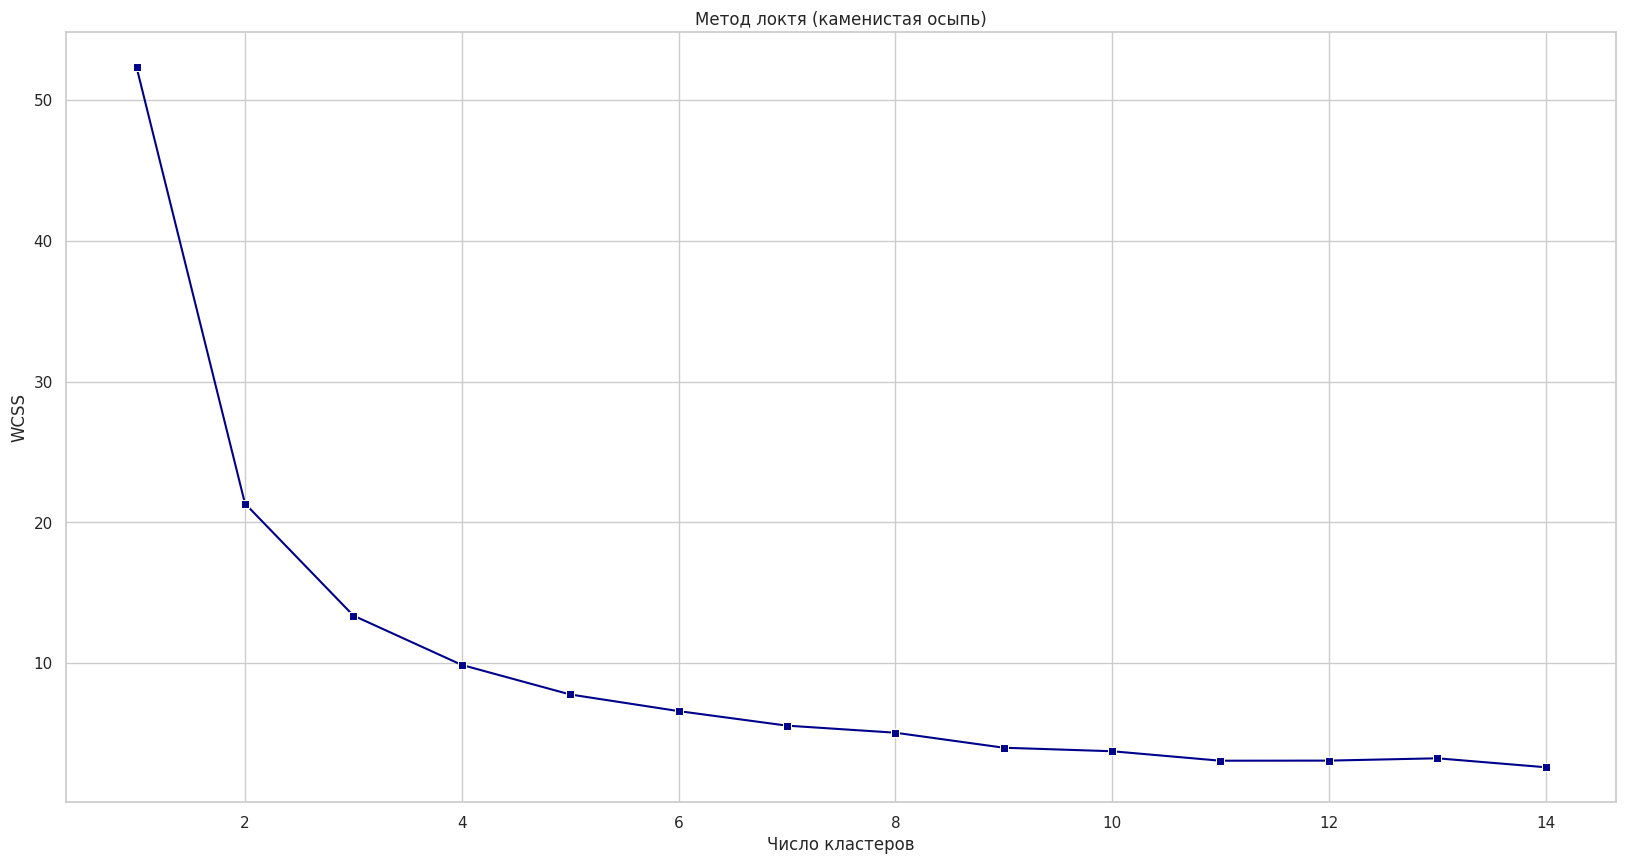

In [ ]:
# График
plt.figure(figsize=(20, 10))
sns.lineplot(x=range(1, 15), y=wcss, marker='s', color='darkblue')
plt.title('Метод локтя (каменистая осыпь)')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

График более плавный, резких надломов нет, возможно 3, 4 или 5.




In [ ]:
model = KMeans(n_clusters = 5, random_state = 1)
model.fit(X1)
df_score['Cluster'] = model.labels_
df_score.groupby('Cluster').mean()

,Age,Score
Cluster,,
0,55.844444,49.066667
1,30.016393,81.131148
2,50.000000,18.111111
3,27.116279,47.023256
4,41.212121,16.212121


Выше всего оценка трат у людей 25 и 33 лет, средняя в 28 и 55, а меньше всего в 41, что явно требует дополнительных исследований.

<Axes: xlabel='Score', ylabel='Age'>

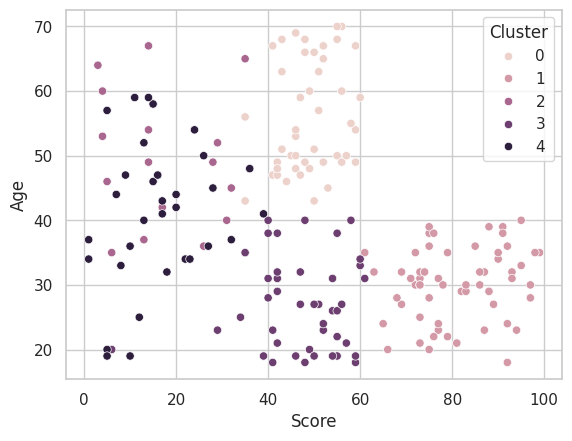

In [ ]:
sns.scatterplot(data = df_score, x = "Score", y = "Age", hue = "Cluster")

In [ ]:
model = KMeans(n_clusters = 4, random_state = 1)
model.fit(X1)
df_score['Cluster'] = model.labels_
df_score.groupby('Cluster').mean()

,Age,Score
Cluster,,
0,41.212121,16.212121
1,30.016393,81.131148
2,55.338983,41.661017
3,27.957447,44.638298


<Axes: xlabel='Score', ylabel='Age'>

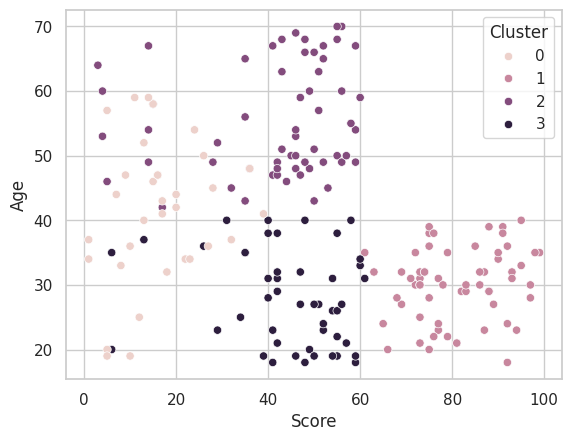

In [ ]:
sns.scatterplot(data = df_score, x = "Score", y = "Age", hue = "Cluster")

In [ ]:
model = KMeans(n_clusters = 3, random_state = 1)
model.fit(X1)
df_score['Cluster'] = model.labels_
df_score.groupby('Cluster').mean()

,Age,Score
Cluster,,
0,29.281250,36.890625
1,30.016393,81.131148
2,54.200000,36.400000


Разделение на 3 кластера по возрастам имеет смысл: начиная с определенного возраста (примерно 42 года) траты остаются минимальными или средними; а в молодом возрасте есть либо многотратящие, либо мало и умеренно. Это может быть связано с наличием детей и возрастом этих детей.

<Axes: xlabel='Score', ylabel='Age'>

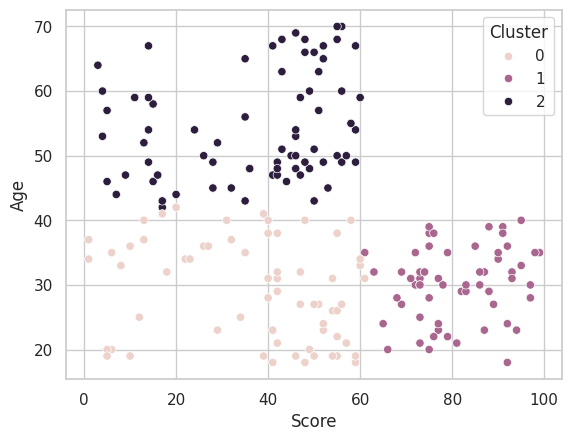

In [ ]:
sns.scatterplot(data = df_score, x = "Score", y = "Age", hue = "Cluster")